In [ ]:
import os
import kagglehub
from diffusers import StableDiffusionImg2ImgPipeline, UNet2DConditionModel
from transformers import AutoTokenizer, AutoModel

import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

path = os.path.join(path, "COVID-19_Radiography_Dataset")

normal_images_path = os.path.join(path, "Normal/images")
abnormal_images_path = os.path.join(path, "COVID/images")
abnormal_masks_path = os.path.join(path, "COVID/masks")


device = "cuda" if torch.cuda.is_available() else "cpu"


100%|██████████| 778M/778M [00:20<00:00, 39.2MB/s]

Extracting files...


In [ ]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device) #torch_dtype=torch.float16
pipe.safety_checker = None
pipe.requires_safety_checker = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("StanfordAIMI/RadBERT")
radbert = AutoModel.from_pretrained("StanfordAIMI/RadBERT").to(device)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# ## 6. Data Preprocessing
# Transform for input images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image.resize((512, 512))
    # return transform(image).unsqueeze(0).to(device)

In [ ]:
# ## 7. Train Latent Diffusion Model
# Initialize U-Net
# unet = pipe.unet.to("cuda")
# optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)

# # Training step
# def train_step(input_image, target_prompt):
#     unet.train()
#     optimizer.zero_grad()

#     # Add Gaussian noise
#     noise = torch.randn_like(input_image) * 0.5
#     noisy_input = input_image + noise

#     # Encode text prompt
#     inputs = tokenizer(target_prompt, return_tensors="pt").to("cuda")
#     text_embedding = radbert(**inputs).last_hidden_state

#     # Forward pass
#     output = unet(noisy_input, text_condition=text_embedding)
#     loss = ((output - input_image) ** 2).mean()

#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # Sample training loop
# image_files = os.listdir(abnormal_images_path)[:10]  # Use a subset for training
# for epoch in range(5):  # Set the number of epochs
#     for image_file in image_files:
#         input_image = preprocess_image(os.path.join(abnormal_images_path, image_file))
#         loss = train_step(input_image, "normal chest x-ray")
#         print(f"Epoch {epoch + 1}, Loss: {loss}")

In [ ]:
# ## 8. Generate Visual Attribution Maps
def generate_attribution_map(input_image, target_prompt):

    # Encode text prompt
    inputs = tokenizer(target_prompt, return_tensors="pt").to(device)
    text_embedding = radbert(**inputs).last_hidden_state

    # Generate healthy counterpart
    with torch.no_grad():
      # strength 0.85 and scale 7.5
      healthy_image = pipe(image=input_image, prompt_embeds=text_embedding, strength=0.1, guidance_scale=2, num_inference_steps=75).images[0]

    # Subtract to create attribution map
    # Convert images to NumPy arrays
    diseased_array = np.array(input_image) / 255.0  # Scale to [0, 1]
    healthy_array = np.array(healthy_image) / 255.0

    # Compute the discrepancy map (absolute difference)
    discrepancy_map = np.abs(diseased_array - healthy_array)

    attribution_map = discrepancy_map #- healthy_image
    return healthy_image, attribution_map

# Test the function
test_image = os.path.join(abnormal_images_path, "COVID-1.png")  # Adjust filename
input_image = preprocess_image(test_image)

healthy_image, attribution_map = generate_attribution_map(input_image, "normal chest x-ray")


  0%|          | 0/11 [00:00<?, ?it/s]

Image similarity 0.9288939324237235


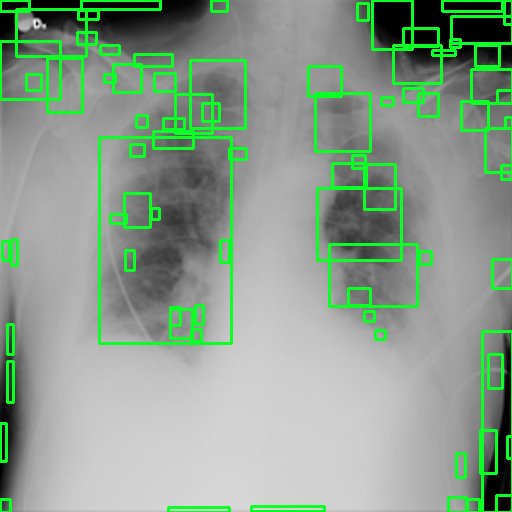

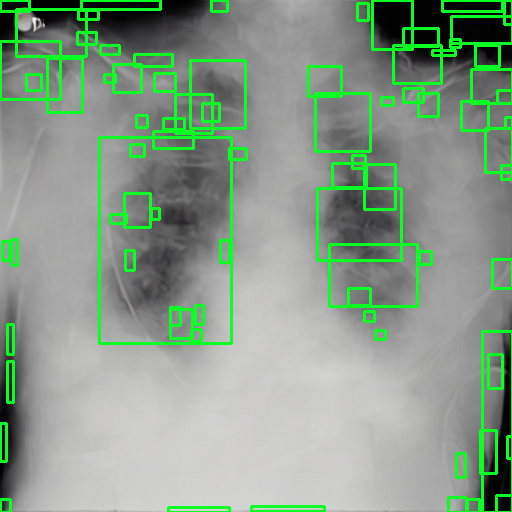

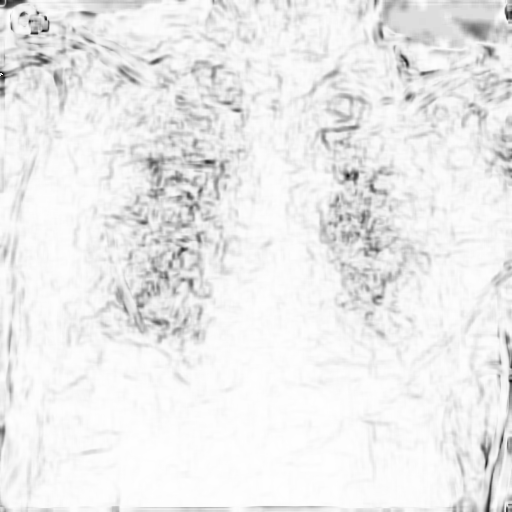

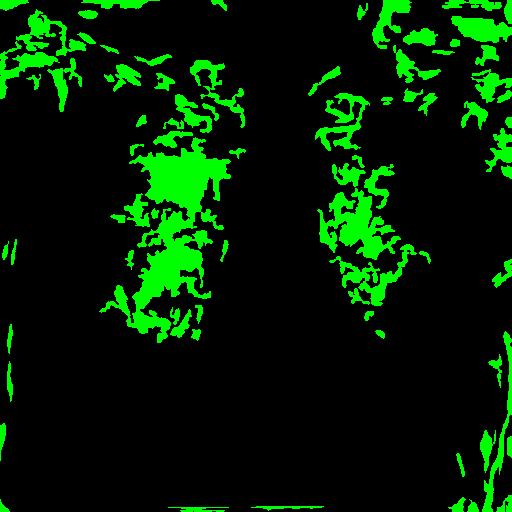

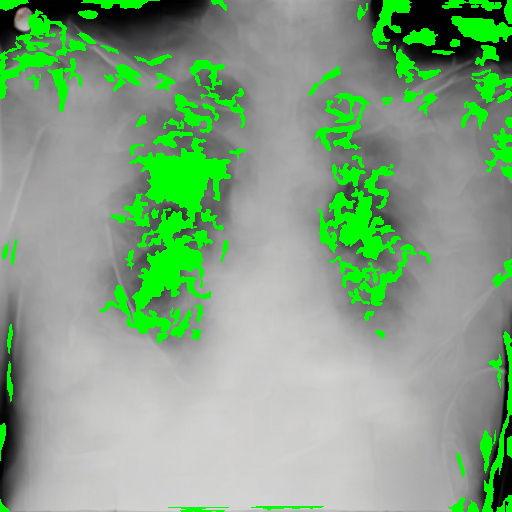

-1

In [ ]:
# Convert images to grayscale
before = np.array(input_image)
after = np.array(healthy_image)

before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)


# Compute SSIM between two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image similarity", score)

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype='uint8')
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled_after, [c], 0, (0,255,0), -1)

cv2_imshow(before)
cv2_imshow(after)
cv2_imshow(diff)
cv2_imshow(mask)
cv2_imshow(filled_after)
cv2.waitKey(0)


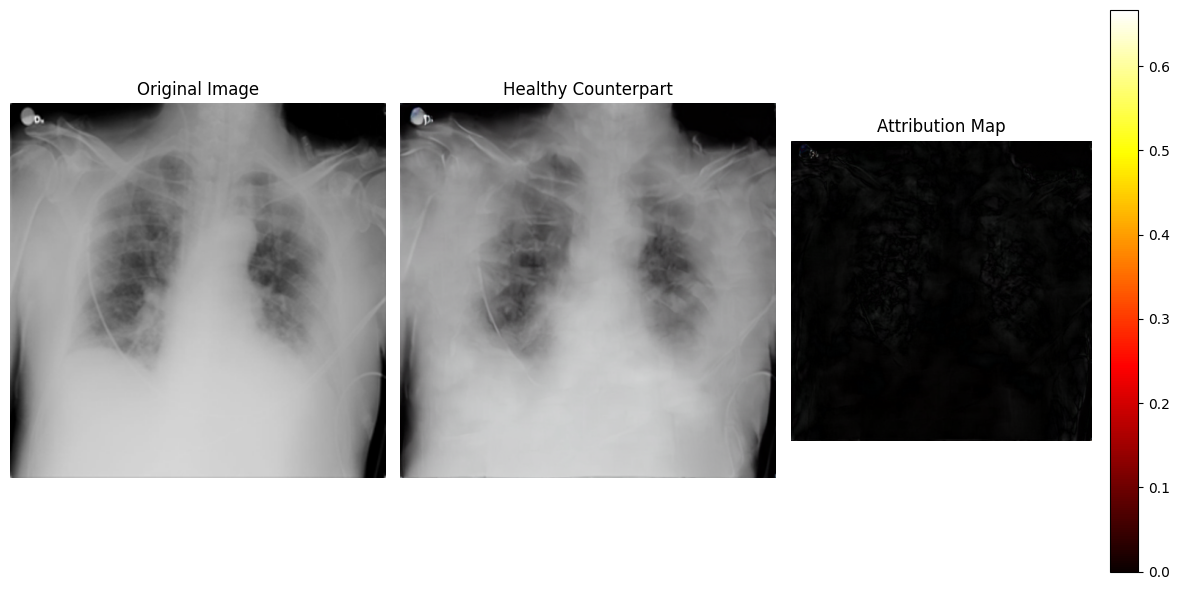

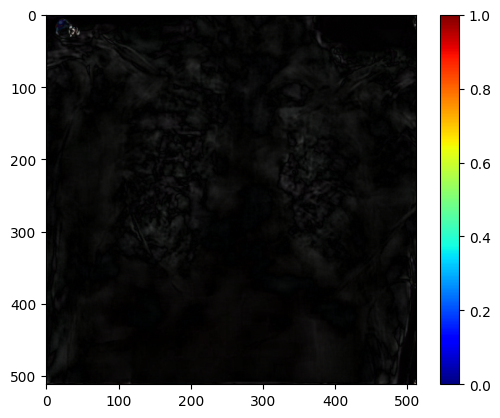

In [ ]:
### Visualizue original image, healthy counterfactual, and attribution map

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Generated Healthy Counterpart
plt.subplot(1, 3, 2)
# tt = healthy_image.transpose(1, 2, 0)
plt.imshow(healthy_image, cmap="gray")  # Convert channel-first to channel-last
plt.title("Healthy Counterpart")
plt.axis("off")

# Attribution Map
plt.subplot(1, 3, 3)
plt.imshow(attribution_map, cmap="hot")
#plt.imshow(attribution_map[0].detach().cpu().numpy(), cmap="hot")  # Visualization in heatmap
plt.title("Attribution Map")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

discrepancy_map_normalized = attribution_map / np.max(attribution_map)
plt.imshow(discrepancy_map_normalized, cmap="jet")
plt.colorbar()
plt.show()